# Produce $\pi$ acceptance maps using GEMC simulation results

last edit Feb-10, 2021

## Imports and definitions

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
r2d = 180./np.pi

In [2]:
import matplotlib as mpl
cmap = mpl.cm.hot

In [3]:
main_data_path     = '/Users/erezcohen/Desktop/data/BAND/AcceptanceCorrection/GEMCimulationOuputFiles/'

In [4]:
pi_charge_names  = ['piplus'   ,'piminus'  ]
pi_labels        = ['\pi^{+}'  ,'\pi^{-}'  ]
pi_colors        = ['royalblue','salmon'   ]

In [5]:
p_min     = 1.25 # GeV/c
p_max     = 5.00 # GeV/c
theta_min = 3    # deg.
theta_max = 40   # deg.
phi_min   = -180 # deg.
phi_max   = 180  # deg.
delta_Vz_resolution = 0.5; # 1\sigma = 5 mm momentum resolution for CLAS

## Auxiliary

In [59]:
def create_2d_acceptance_map(x_var_g='pi_P_g',
                             y_var_g='pi_Theta_g', 
                             x_function=None, 
                             y_function='cos',
                             bins = (np.linspace(0.75, 1,31),
                                     np.linspace(p_min, p_max,31)), 
                             acc_type = 'PID+fiducial'):
    # h_gen,h_acc,h_eff,xedges,yedges = create_2d_acceptance_map(x_var_g, y_var_g, x_function, y_function,bins)
    # acc_type = 'rec', 'PID' , 'fiducial', 'PID+fiducial'
    
    df_gen = eepi_GEMC;
    if acc_type=='rec': # only "reconstructed"
        df_acc = eepi_GEMC[eepi_GEMC.pi_reconstructed==1];
    elif acc_type=='PID':
        df_acc = eepi_GEMC[eepi_GEMC.pi_passed_PID_cuts==1];
    elif acc_type=='fiducial':
        df_acc = eepi_GEMC[eepi_GEMC.pi_passed_fiducial_cuts==1];
    elif acc_type=='PID+fiducial':
        df_acc = eepi_GEMC[eepi_GEMC.pi_passed_cuts==1];

    

    # note the inverted order: y then x
    # [https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html]
    # Histogram does not follow Cartesian convention (see Notes), 
    # therefore transpose H for visualization purposes.

    if x_function is None:
        x_gen,x_acc = df_gen[x_var_g],     df_acc[x_var_g]    
    elif x_function == 'cos':
        x_gen,x_acc = np.cos(df_gen[x_var_g]), np.cos(df_acc[x_var_g])
    elif x_function == 'r2d':
        x_gen,x_acc = df_gen[x_var_g]*r2d,     df_acc[x_var_g]*r2d    


    if y_function is None:
        y_gen,y_acc = df_gen[y_var_g],     df_acc[y_var_g]    
    elif y_function == 'cos':
        y_gen,y_acc = np.cos(df_gen[y_var_g]), np.cos(df_acc[y_var_g])
    elif y_function == 'r2d':
        y_gen,y_acc = df_gen[y_var_g]*r2d,     df_acc[y_var_g]*r2d    


    h_gen, yedges, xedges = np.histogram2d( y_gen , x_gen , bins=bins )
    h_acc, yedges, xedges = np.histogram2d( y_acc , x_acc , bins=bins )

    h_eff = np.ones([len(xedges)-1,len(yedges)-1])
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            h_eff[i][j] = 100.*float(h_acc[i][j])/np.max([1,h_gen[i][j]])

    print('Done producing acceptance maps')
    return h_gen,h_acc,h_eff,xedges,yedges 

## load data

In [66]:
eepi_GEMC = pd.read_csv( main_data_path + 'eepips_p_uniform_distribution.csv')
Nevents      = len(eepi_GEMC)
print('%.1f'%(100.*len(eepi_GEMC[eepi_GEMC.pi_reconstructed==1]) /Nevents),'% of the ','%d events include pi+ reconstructed'%Nevents)
print('%.1f'%(100.*len(eepi_GEMC[eepi_GEMC.pi_passed_fiducial_cuts==1]) /Nevents),'% of the ','%d events include pi+ passed fiducial cuts'%Nevents)
print('%.1f'%(100.*len(eepi_GEMC[eepi_GEMC.pi_passed_PID_cuts==1]) /Nevents),'% of the ','%d events include pi+ passed PID cuts'%Nevents)
print('%.1f'%(100.*len(eepi_GEMC[eepi_GEMC.pi_passed_cuts==1]) /Nevents),'% of the ','%d events include pi+ passed all cuts'%Nevents)

65.3 % of the  50013 events include pi+ reconstructed
60.8 % of the  50013 events include pi+ passed fiducial cuts
0.0 % of the  50013 events include pi+ passed PID cuts
0.0 % of the  50013 events include pi+ passed all cuts


## plots

#### 1D acceptance maps in $p,\theta,\phi$

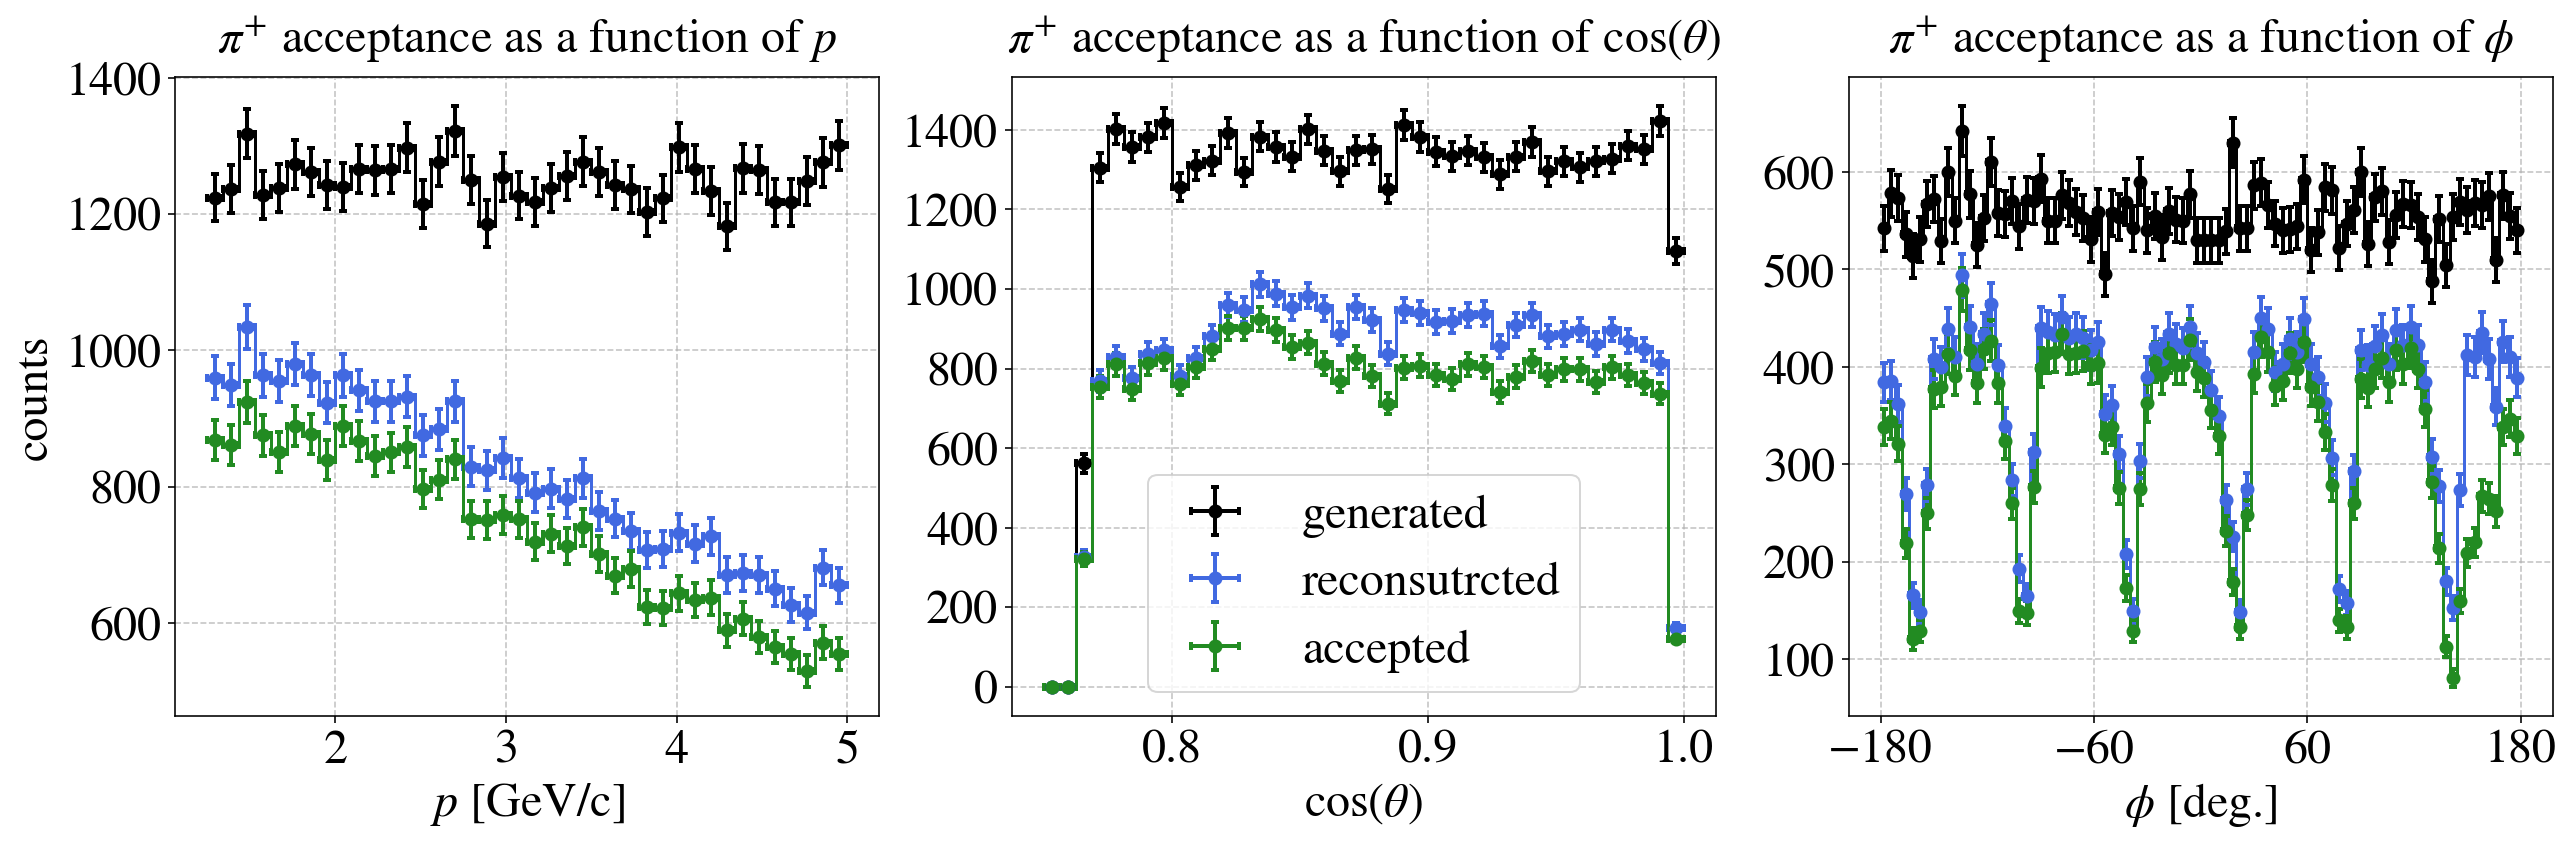

In [15]:
fig = plt.figure(figsize=(18,6))
for (var_gen,
     label,units,bins,
     scale_factor,xticks,
     function,
     subplot_idx) in zip(['pi_P_g','pi_Theta_g','pi_Phi_g'],
                         ['$p$','$\cos(\\theta)$', '$\phi$'], 
                         ['[GeV/c]','', '[deg.]'], 
                         [np.linspace(p_min, p_max,41),
                          np.linspace(0.75,1,41),
                          np.linspace(phi_min, phi_max,91)],
                         [1,r2d,r2d],
                         [[2,3,4,5],[0.8,0.9,1],[-180,-60,60,180]],
                         ['','cos',''],                         
                         range(3)):

    df_gen = eepi_GEMC;
    df_rec = eepi_GEMC[eepi_GEMC.pi_reconstructed==1];
    df_acc = eepi_GEMC[eepi_GEMC.pi_passed_cuts  ==1];    
    x_gen = df_gen[var_gen]
    x_rec = df_rec[var_gen]    
    x_acc = df_acc[var_gen]    
    

                                      
    ax = fig.add_subplot(1,3,subplot_idx+1)
    if function=='cos':
        
        plot_step_hist( np.cos(x_gen), bins, color='k',           label='generated')
        plot_step_hist( np.cos(x_rec), bins, color='royalblue',   label='reconsutrcted')    
        plot_step_hist( np.cos(x_acc), bins, color='forestgreen', label='accepted')    

    else:
        plot_step_hist( x_gen*scale_factor, bins, color='k',           label='generated')
        plot_step_hist( x_rec*scale_factor, bins, color='royalblue',   label='reconsutrcted')
        plot_step_hist( x_acc*scale_factor, bins, color='forestgreen', label='accepted')            
        
    # ax.set_yscale('log')
    set_axes(ax,label + ' ' + units,'counts' if subplot_idx==0 else '',
             do_add_legend=True if subplot_idx==1 else False,
             title='$\pi^{+}$ acceptance as a function of '+label, fontsize=24, do_add_grid=True,xticks=xticks)
plt.tight_layout();

#### The distibution of $z$-vertex difference

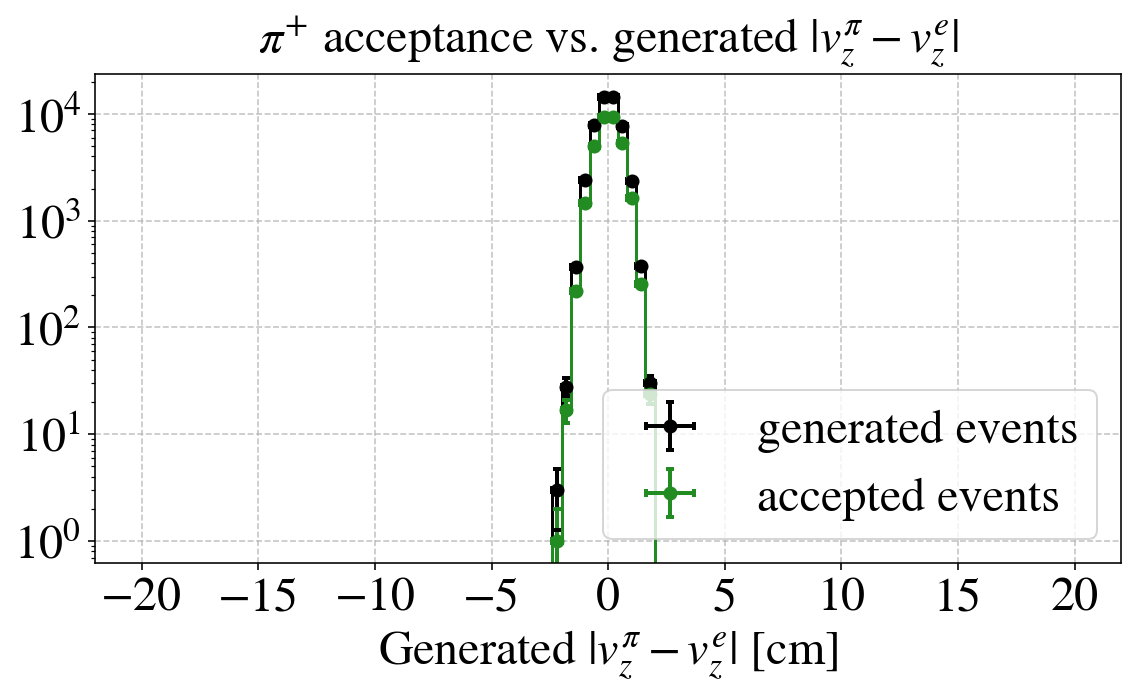

In [16]:
fig = plt.figure(figsize=(8,5))
label = '$|v_z^{\pi}-v_z^{e}|$'
units = '[cm]'
bins = np.linspace(-20,20,101)
df_gen = eepi_GEMC;
df_acc = eepi_GEMC[eepi_GEMC.Npips>0];
                                      
ax = fig.add_subplot(1,1,1)
x_gen = df_gen['pi_Vz_g'] - df_gen['e_Vz_g']
x_acc = df_acc['pi_Vz_g'] - df_acc['e_Vz_g']
plot_step_hist( x_gen, bins, color='k', label='generated events')
plot_step_hist( x_acc, bins, color='forestgreen', label='accepted events')    
ax.set_yscale('log')
set_axes(ax,'Generated '+label + ' ' + units,'counts' if subplot_idx==0 else '',
         do_add_legend=True ,
         title='$\pi^{+}$ acceptance vs. generated '+label, fontsize=24, do_add_grid=True);

# a plot of reconsutrcted pion vertex for events in which a pion is not reconstructed - makes no sense
# ax = fig.add_subplot(1,2,2)
# x_gen = df_gen['pi_Vz'] - df_gen['e_Vz']
# x_acc = df_acc['pi_Vz'] - df_acc['e_Vz']
# plot_step_hist( x_gen, bins, color='k', label='generated events')
# plot_step_hist( x_acc, bins, color='forestgreen', label='accepted events')    
# ax.set_yscale('log')
# set_axes(ax,'Reconstructed '+label + ' ' + units,'counts' if subplot_idx==0 else '',
#          do_add_legend=False,
#          title='$\pi^{+}$ acceptance vs. reconstructed '+label, fontsize=24, do_add_grid=True);

plt.tight_layout()

#### 2D acceptance maps in $p -\theta$ and $\theta-\phi$

#### create maps

#### plot maps

Done producing acceptance maps


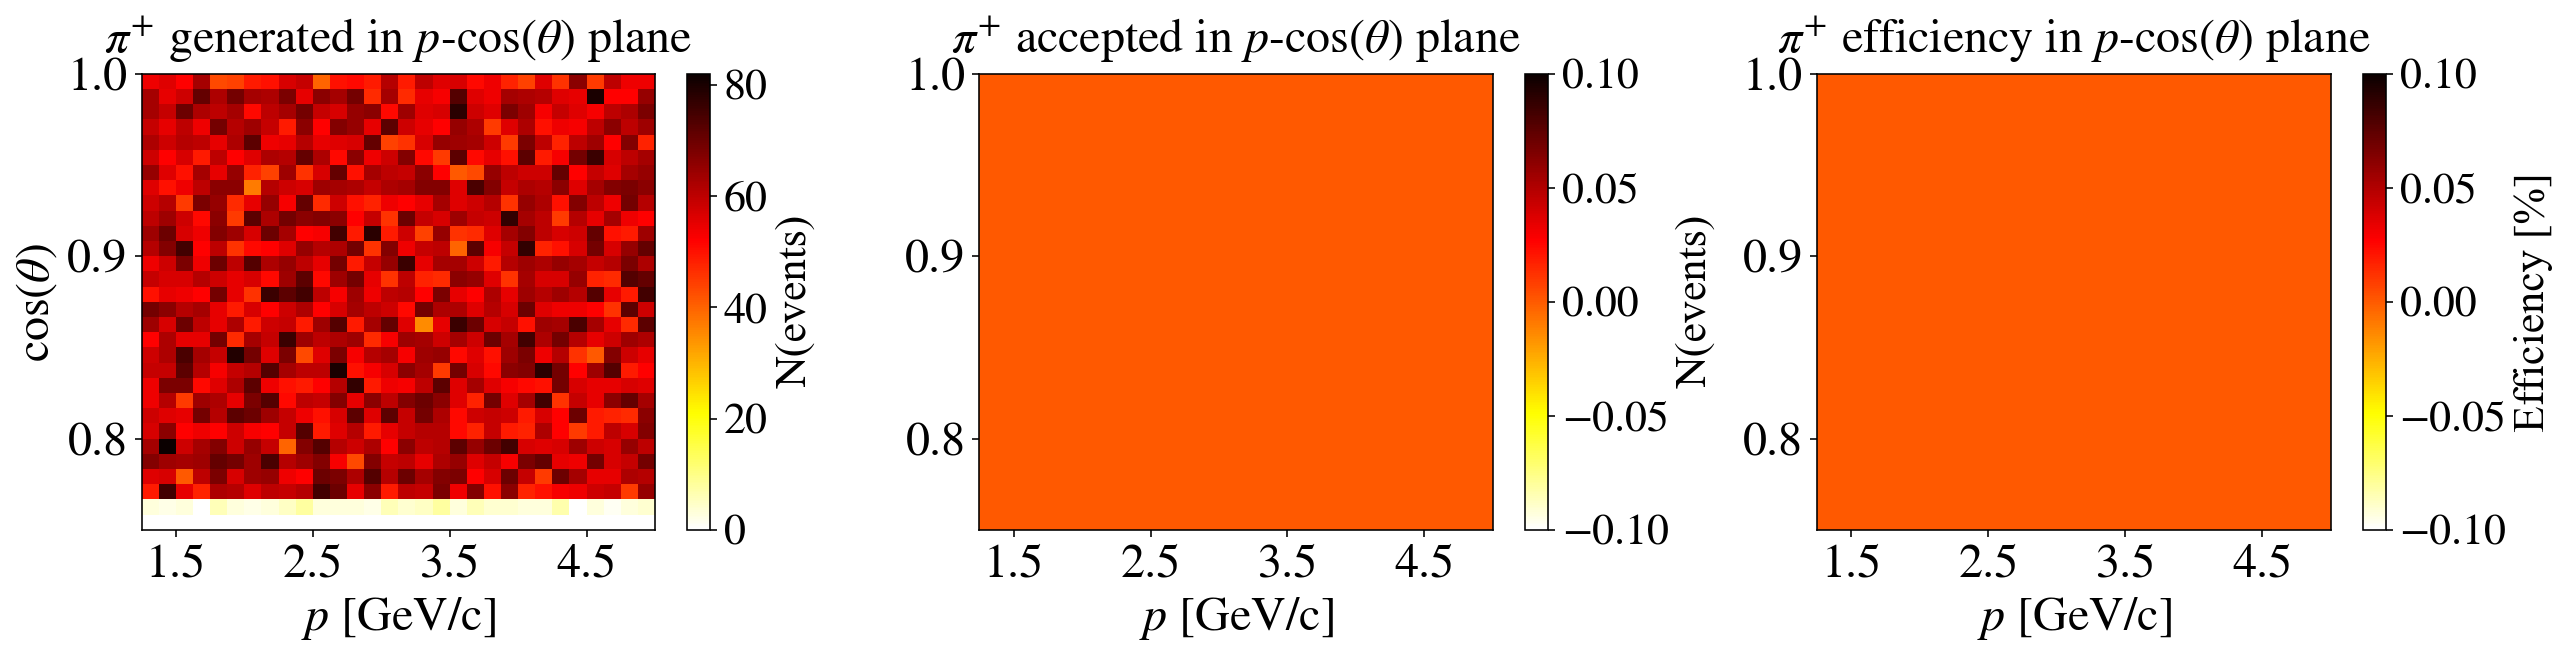

In [60]:
x_var_g, xlabel, xunits = 'pi_P_g', '$p$','[GeV/c]'
y_var_g, ylabel, yunits = 'pi_Theta_g', '$\cos(\\theta)$',''
h_gen,h_acc,h_eff,xedges,yedges  = create_2d_acceptance_map(x_var_g=x_var_g, y_var_g=y_var_g, 
                                 y_function='cos',
                                 bins = (np.linspace(0.75, 1,31),np.linspace(p_min, p_max,31)))
xticks = [1.5,2.5,3.5,4.5]
yticks = [0.8,0.9,1]
extent=[p_min,p_max,theta_min,theta_max]

fig = plt.figure(figsize=(18,8))
for h,hlabel,cbarunits,subplot_idx in zip([h_gen,h_acc,h_eff],
                                          ['generated','accepted','efficiency'],
                                          ['N(events)','N(events)','Efficiency [%]'],
                                          [1,2,3]):
    ax = fig.add_subplot(2,3,subplot_idx)
    im = ax.pcolormesh(xedges, yedges, h, cmap='hot_r')
    # colorbar
    cbar = plt.colorbar( im, label=cbarunits )    
    cbar.ax.tick_params(labelsize=22)
    cbar.ax.yaxis.label.set_font_properties(mpl.font_manager.FontProperties(family='times new roman', size=22))
    # cosmetics
    set_axes(ax, xlabel + ' ' + xunits,ylabel + ' ' + yunits if subplot_idx==1 else '',
                 title='$\pi^{+}$ '+hlabel+' in '+xlabel+'-'+ylabel+' plane',
             fontsize=24, do_add_grid=False,xticks=xticks,yticks=yticks)
    
plt.tight_layout();

Done producing acceptance maps


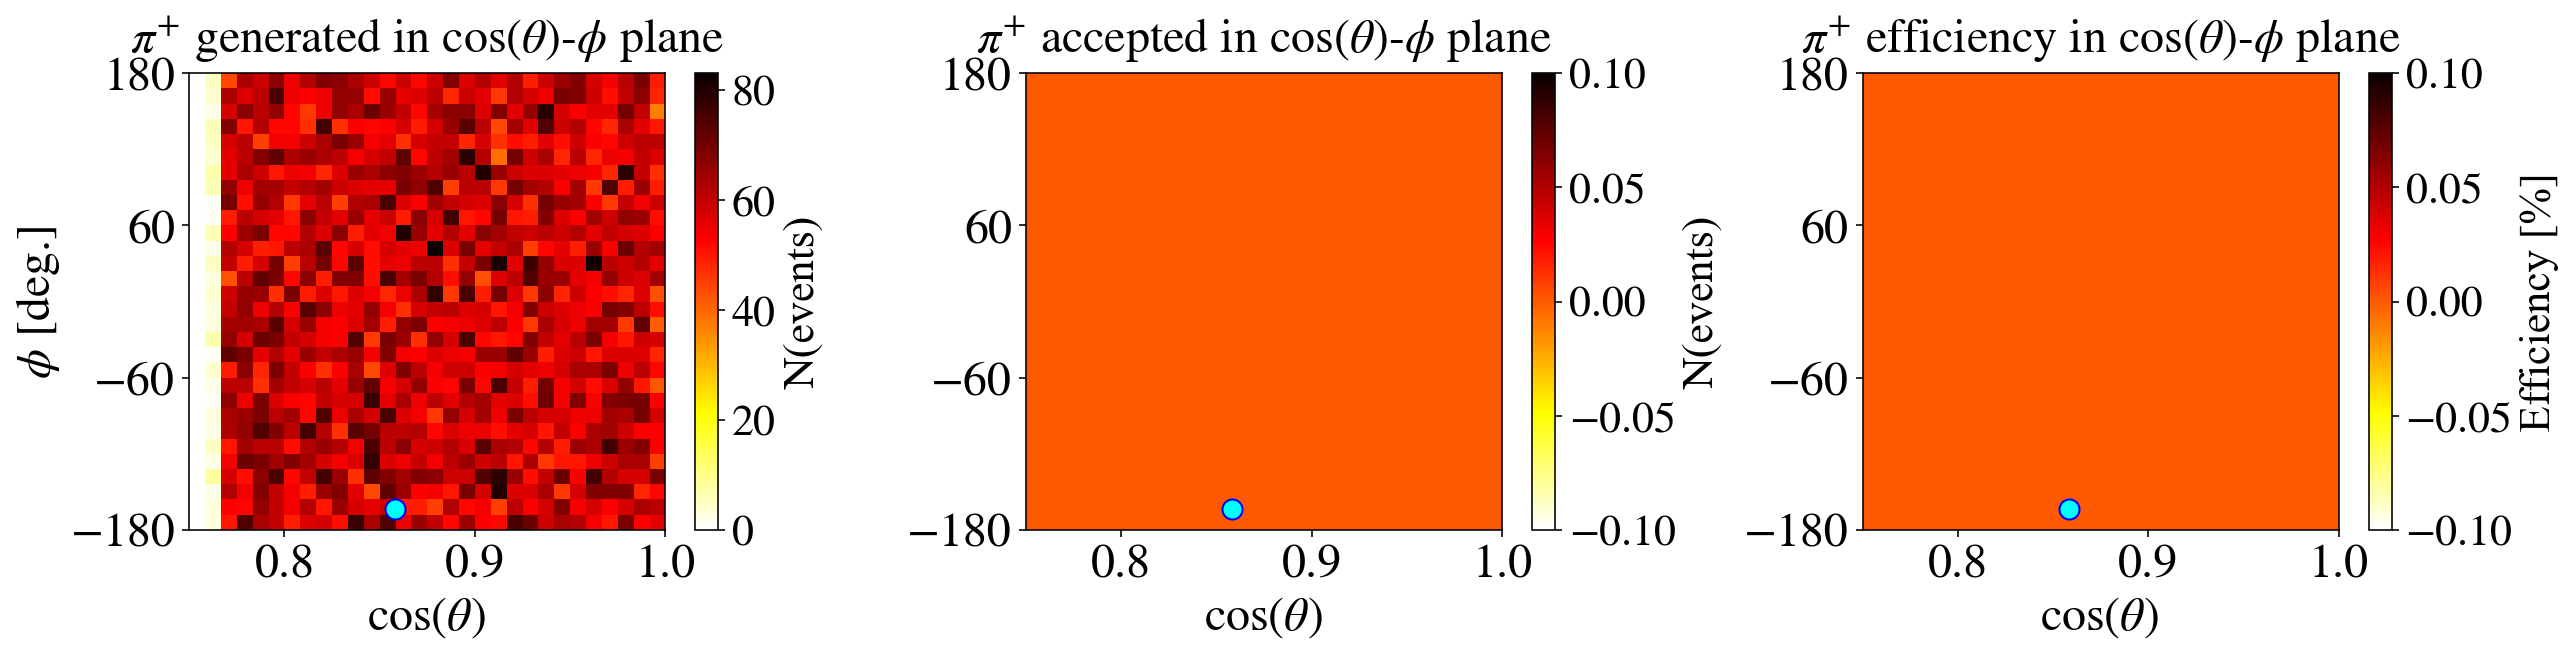

In [61]:
x_var_g, xlabel, xunits = 'pi_Theta_g', '$\cos(\\theta)$',''
y_var_g, ylabel, yunits = 'pi_Phi_g', '$\phi$','[deg.]'


h_gen,h_acc,h_eff,xedges,yedges  = create_2d_acceptance_map(x_var_g=x_var_g, y_var_g=y_var_g, 
                                 x_function='cos',y_function='r2d',
                                 bins = (np.linspace(phi_min, phi_max,31),np.linspace(0.75, 1,31)),
                                                            # acc_type = 'rec'
                                                            acc_type = 'PID'
                                                           # acc_type = 'fiducial'
                                                           )

# h_gen,h_acc,h_eff,xedges,yedges  = create_2d_acceptance_map(x_var_g=x_var_g, y_var_g=y_var_g, 
#                                  x_function='cos',y_function='r2d',
#                                  bins = (np.linspace(phi_min, phi_max,31),np.linspace(0.75, 1,31)),
#                                                            acc_type = 'PID')

# h_gen,h_acc,h_eff,xedges,yedges  = create_2d_acceptance_map(x_var_g=x_var_g, y_var_g=y_var_g, 
#                                  x_function='cos',y_function='r2d',
#                                  bins = (np.linspace(phi_min, phi_max,31),np.linspace(0.75, 1,31)),
#                                                            acc_type = 'PID+fiducial')



xticks = [0.8,0.9,1]
yticks = [-180,-60,60,180]

extent=[p_min,p_max,theta_min,theta_max]

fig = plt.figure(figsize=(18,8))
for h,hlabel,cbarunits,subplot_idx in zip([h_gen,h_acc,h_eff],
                                          ['generated','accepted','efficiency'],
                                          ['N(events)','N(events)','Efficiency [%]'],
                                          [1,2,3]):
    ax = fig.add_subplot(2,3,subplot_idx)
    im = ax.pcolormesh(xedges, yedges, h, cmap='hot_r')
    # colorbar
    cbar = plt.colorbar( im, label=cbarunits )    
    cbar.ax.tick_params(labelsize=22)
    cbar.ax.yaxis.label.set_font_properties(mpl.font_manager.FontProperties(family='times new roman', size=22))
    # cosmetics
    set_axes(ax, xlabel + ' ' + xunits,ylabel + ' ' + yunits if subplot_idx==1 else '',
                 title='$\pi^{+}$ '+hlabel+' in '+xlabel+'-'+ylabel+' plane',
             fontsize=24, do_add_grid=False,xticks=xticks,yticks=yticks)
    
    theta_e = 30.9 # deg.
    phi_e = -163.4
    plt.scatter([np.cos(theta_e/r2d)],[phi_e],s=100,marker='o',color='cyan',edgecolor='blue')
    
plt.tight_layout();

Done producing acceptance maps


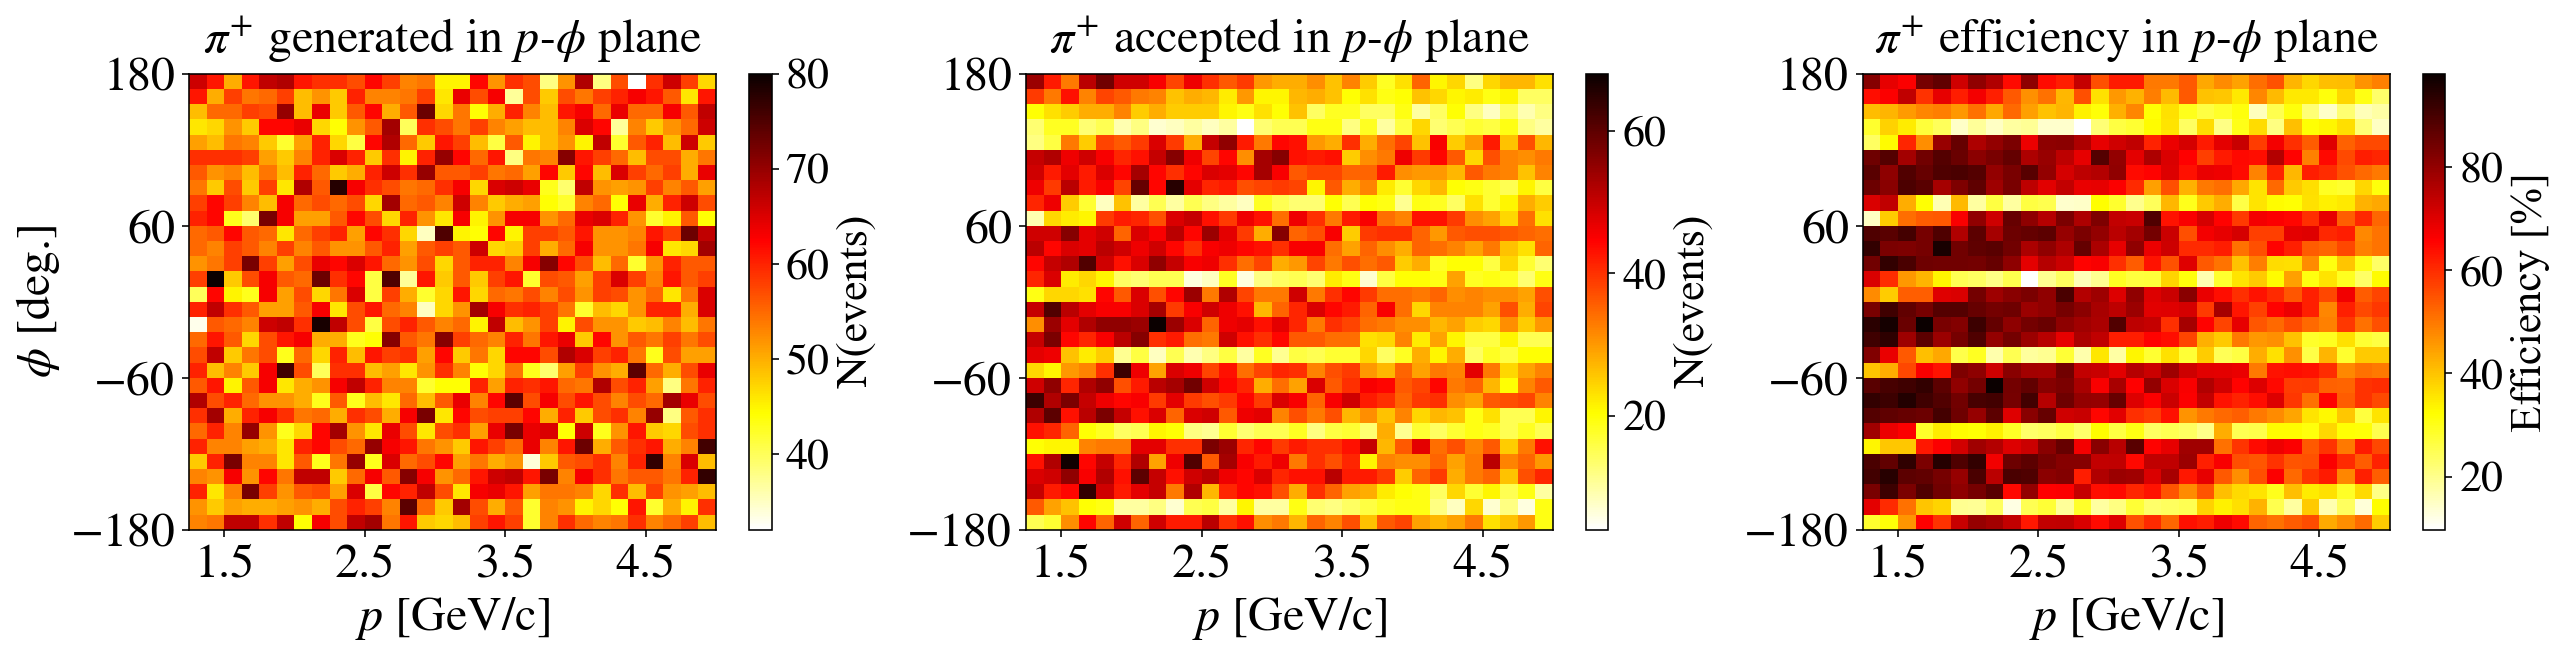

In [32]:
x_var_g, xlabel, xunits = 'pi_P_g', '$p$','[GeV/c]'
y_var_g, ylabel, yunits = 'pi_Phi_g', '$\phi$','[deg.]'
h_gen,h_acc,h_eff,xedges,yedges  = create_2d_acceptance_map(x_var_g=x_var_g, y_var_g=y_var_g, 
                                                            y_function='r2d',
                                 bins = (np.linspace(phi_min, phi_max,31),np.linspace(p_min, p_max,31)))


xticks = [1.5,2.5,3.5,4.5]
yticks = [-180,-60,60,180]

extent=[p_min,p_max,theta_min,theta_max]

fig = plt.figure(figsize=(18,8))
for h,hlabel,cbarunits,subplot_idx in zip([h_gen,h_acc,h_eff],
                                          ['generated','accepted','efficiency'],
                                          ['N(events)','N(events)','Efficiency [%]'],
                                          [1,2,3]):
    ax = fig.add_subplot(2,3,subplot_idx)
    im = ax.pcolormesh(xedges, yedges, h, cmap='hot_r')
    # colorbar
    cbar = plt.colorbar( im, label=cbarunits )    
    cbar.ax.tick_params(labelsize=22)
    cbar.ax.yaxis.label.set_font_properties(mpl.font_manager.FontProperties(family='times new roman', size=22))
    # cosmetics
    set_axes(ax, xlabel + ' ' + xunits,ylabel + ' ' + yunits if subplot_idx==1 else '',
                 title='$\pi^{+}$ '+hlabel+' in '+xlabel+'-'+ylabel+' plane',
             fontsize=24, do_add_grid=False,xticks=xticks,yticks=yticks)
    
plt.tight_layout();